In [1]:
from google.colab import drive

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import pandas as pd

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/My Drive/NBSVM/train.csv')

In [6]:
df_test = pd.read_csv('/content/drive/My Drive/NBSVM/test.csv')

In [7]:
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [8]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

There are no null values in the dataset

In [9]:
df.shape

(159571, 8)

In [10]:
features = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
df[features].dtypes

toxic            int64
severe_toxic     int64
obscene          int64
threat           int64
insult           int64
identity_hate    int64
dtype: object

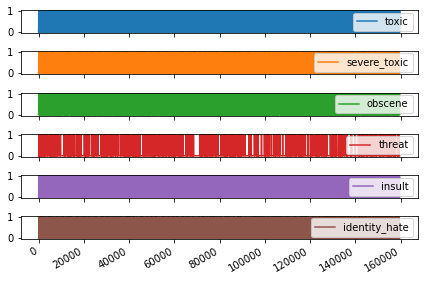

In [11]:
df.plot(subplots=True)

plt.tight_layout()
plt.show()

In [12]:
df['threat'].isnull().sum()

0

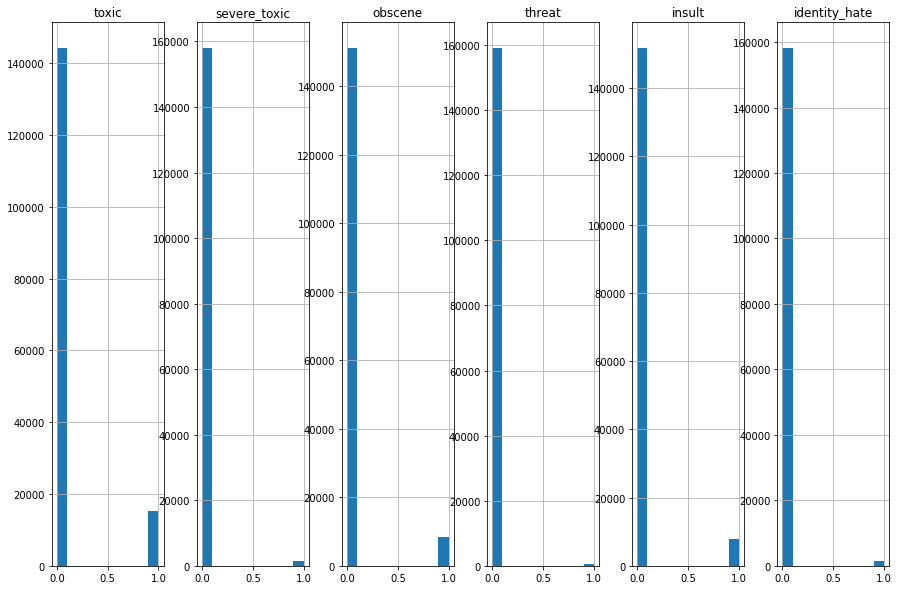

In [13]:
df.hist(layout=(1,6), figsize=(15,10))

plt.show()

As we notice from the Histogram plots that the number of 1's are very less compared to the number of 0's. 

In [14]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [15]:
train_text = df['comment_text']
test_text = df_test['comment_text']

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re,string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

vec2 = TfidfVectorizer(ngram_range=(1,2), 
                      tokenizer=tokenize,
                      min_df=3, 
                      max_df=0.9, 
                      strip_accents='unicode', 
                      use_idf=1,
                      smooth_idf=1, 
                      sublinear_tf=1)
train_term_doc = vec2.fit_transform(train_text)
test_term_doc = vec2.transform(test_text)

In [26]:
# nbsvm
from sklearn.linear_model import LogisticRegression
import pickle
train_x = train_term_doc
test_x = test_term_doc

def pr(y_i, y):
    p = train_x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

def get_mdl(y,name):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, solver='liblinear', dual=True)
    x_nb = train_x.multiply(r)
    pickle.dump(m.fit(x_nb, y), open(name+'.pkl','wb'))
    return m.fit(x_nb, y), r

def get_model(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, solver='liblinear', dual=True)
    x_nb = train_x.multiply(r)
    #pickle.dump(m.fit(x_nb, y), open(name+'.pkl','wb'))
    return m.fit(x_nb, y), r


In [21]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
roc_auc = []
for i, j in enumerate(features):
  train_target = df[j]
  m,r = get_mdl(df[j],j)
  y_pred = m.predict_proba(train_x.multiply(r))[:,1]
  roc_auc.append(roc_auc_score(train_target, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

In [22]:
for i in roc_auc:
  print(i)

0.9994655101823582
0.9999390864181107
0.9997115570874476
0.9999991255345055
0.9996448269649252
0.9999922532851314


In [23]:
sub = pd.read_csv('/content/drive/My Drive/NBSVM/sample_submission.csv')
sub.columns

Index(['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [24]:
sub.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [27]:
for i, j in enumerate(features):
  train_target = df[j]
  m,r = get_model(df[j])
  y_pred = m.predict_proba(test_x.multiply(r))[:,1]
  sub[j] = y_pred


  

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

In [28]:
sub.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999988,0.108557,0.999987,0.002368,0.962587,0.094301
1,0000247867823ef7,0.002873,0.000604,0.001893,0.000100,0.002227,0.000342
2,00013b17ad220c46,0.011755,0.000864,0.005588,0.000102,0.003210,0.000297
3,00017563c3f7919a,0.000960,0.000224,0.001141,0.000171,0.001057,0.000297
4,00017695ad8997eb,0.009957,0.000484,0.002009,0.000131,0.002395,0.000351


In [29]:
sub.to_csv('sample_submission.csv', index=False)